# Looking for the Signal with a NN

In this chapter we will implement a small simple fully connected NN that will separate the signal and background. In the next chapter we will add a selection cut in front of the NN.

To make this minimally interesting, we'll move to a 2D dataset with the signal and background overlapping. The goal is to build a dataset that will need more than just simple cuts to get the best behavior.

In [1]:
import jax
import jax.numpy as jnp
import numpy
import matplotlib.pyplot as plt
from samples import data_back, sig_avg, sig_width
from jax_helpers import erf, train
import haiku as hk

_ = plt.ion()

Load up the 2D data.
* To avoid normalization issues, we make the data sets the same size.

In [2]:
key = jax.random.PRNGKey(1234)
signal_data = jax.random.multivariate_normal(key, jnp.asarray([1.5, 2.0]), jnp.asarray([[0.5, 0.2], [0.2, 0.5]]), [40000])
key, _ = jax.random.split(key)
background_data = jax.random.multivariate_normal(key, jnp.asarray([0.0, 0.0]), jnp.asarray([[9.0, 0.0], [0.0, 9.0]]), [40000])

The signal and background data is shown below, as a contour plot. The data located at $0,0$ is the background, and the offset (at $3,5$) is the signal. As you can see, there is substantial overlap making it quite hard to separate the signal.

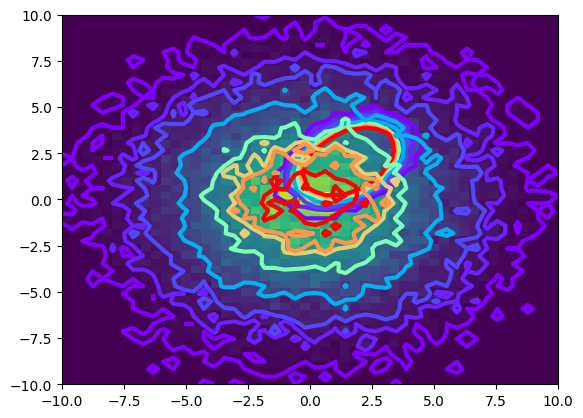

In [3]:
def plot_contour(data):
    counts,xbins,ybins,_ = plt.hist2d(data[:, 0], data[:, 1], bins=50, range=((-10, 10), (-10, 10)))
    plt.contour(counts.transpose(),extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]], linewidths=3, cmap = plt.cm.rainbow, levels = [1,5,10,25,50,70,80,100])

plot_contour(signal_data)
plot_contour(background_data)

Build the training and truth data. Keep the testing and training data the same, and the full data sample.

In [4]:
all_data = jnp.concatenate((signal_data, background_data))
all_truth = jnp.concatenate((jnp.ones(len(signal_data)), jnp.zeros(len(background_data))))

training_data = all_data
training_truth = all_truth

testing_signal = signal_data
testing_background = background_data

## Build and train a simple fully connected network

First define the network. We will use a simple fully connected network, with 6 layers. With extended training this has been shown to do quite well.

In [5]:
def FeedForward(x):
    mlp = hk.nets.MLP(output_sizes=[2,15,30,15,1])
    return mlp(x)

model = hk.transform(FeedForward)

The training is coded in the `jax_helpers` module as we will re-use it a bit!

In [6]:
params = train(model=model,
    key = key, 
    epochs = 2000,
    training_data=training_data,
    training_truth=training_truth)

NegLogLoss : 450086.47, epoch: 1
NegLogLoss : 440696.31, epoch: 200
NegLogLoss : 440081.81, epoch: 400
NegLogLoss : 439910.03, epoch: 600
NegLogLoss : 439677.06, epoch: 800
NegLogLoss : 439542.91, epoch: 1000
NegLogLoss : 439481.50, epoch: 1200
NegLogLoss : 439340.09, epoch: 1400
NegLogLoss : 439237.56, epoch: 1600
NegLogLoss : 439129.94, epoch: 1800
NegLogLoss : 439072.69, epoch: 2000


Going from a simple optimizer to the Adam optimizer in `optax` meant going from what looked like a very simple triangle cut to a circle below. And also going from training on 30K epochs to training about 1000 times (and it looks like we might have been done at 500 too).

I suspect we could have used a simpler network as a result of this as well.

## Examining the Training

Lets look at this graphically, showing a scatter plot of good and bad. First the prediction!

In [7]:
def infer(data):
    test_preds = model.apply(params, key, data)
    test_preds = jax.nn.sigmoid(test_preds.squeeze())
    test_preds = (test_preds > 0.5).astype(jnp.float32)
    return test_preds

infer_signal = infer(testing_signal)
infer_background = infer(testing_background)

And the signal and background prediction values

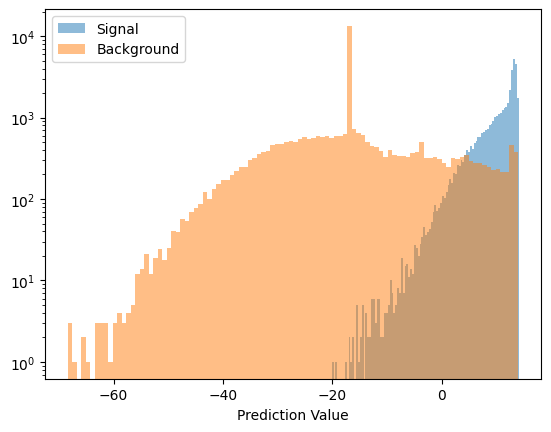

In [10]:
def plot_pred(data, name):
    preds = model.apply(params, key, data)
    preds = preds.squeeze()
    plt.hist(preds, bins=100, label=name, alpha=0.5)

plot_pred(testing_signal, 'Signal')
plot_pred(testing_background, 'Background')

plt.yscale('log')
plt.xlabel('Prediction Value')
plt.legend()
plt.show()

Next, plot the classified signal and background

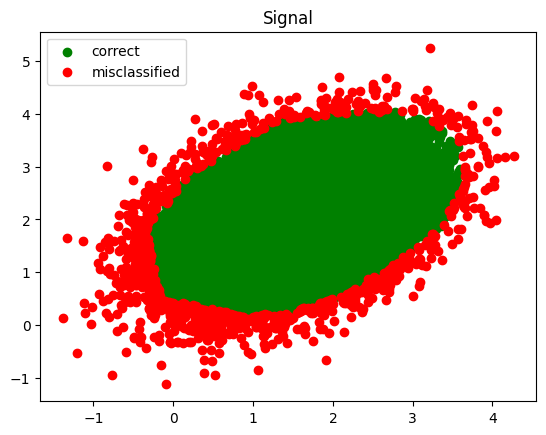

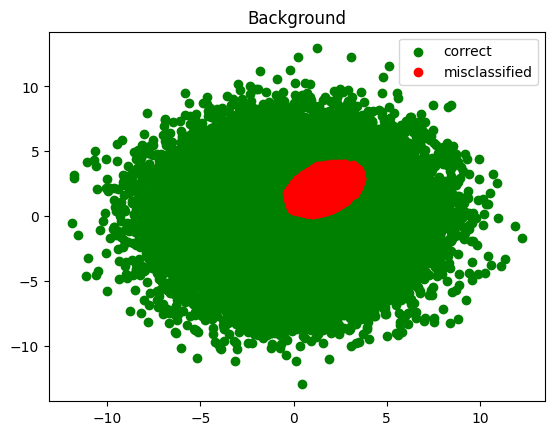

In [9]:
def plot_inference(data, results, value, title):
    good_data = data[results == value]
    plt.scatter(good_data[:, 0], good_data[:, 1], color='green', label='correct')
    bad_data = data[results != value]
    plt.scatter(bad_data[:, 0], bad_data[:, 1], color='red', label='misclassified')
    plt.title(title)
    plt.legend()

plot_inference(testing_signal, infer_signal, 1.0, 'Signal')
plt.show()
plot_inference(testing_background, infer_background, 0.0, 'Background')
plt.show()